In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-10-04 15:34:19,066	INFO worker.py:1636 -- Started a local Ray instance.


0.1 0.0072010264910560605 arcsec / pix


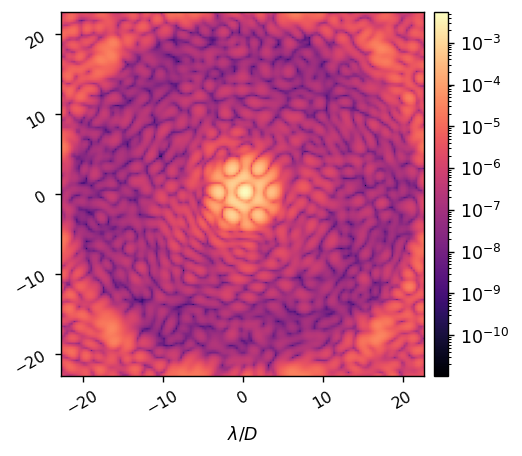

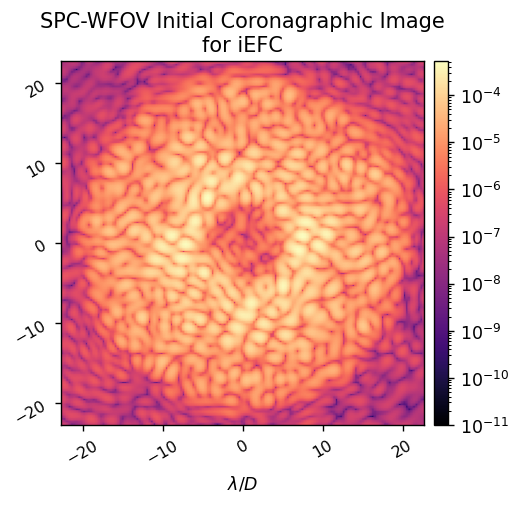

In [2]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True)
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

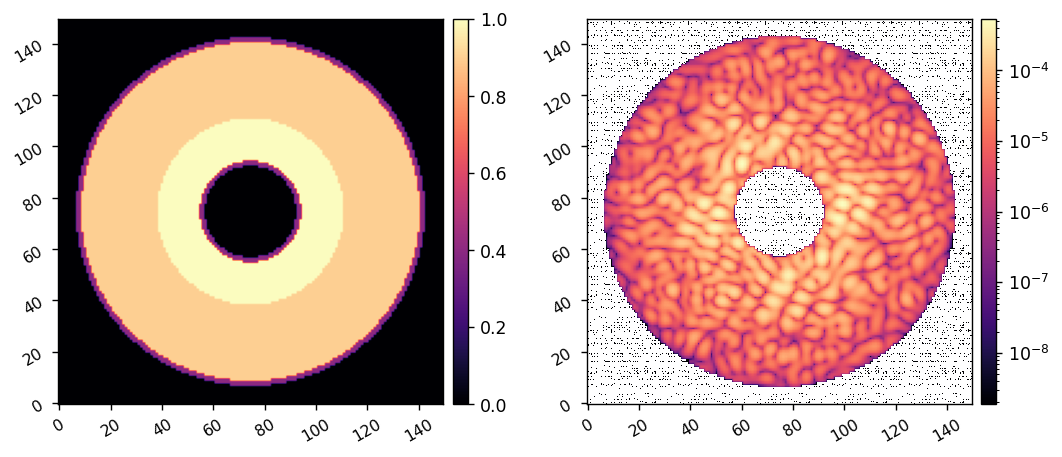

3.042688486608366e-05


In [3]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

control_mask = ensure_np_array(weight_map>0)

4.396214918079946e-09


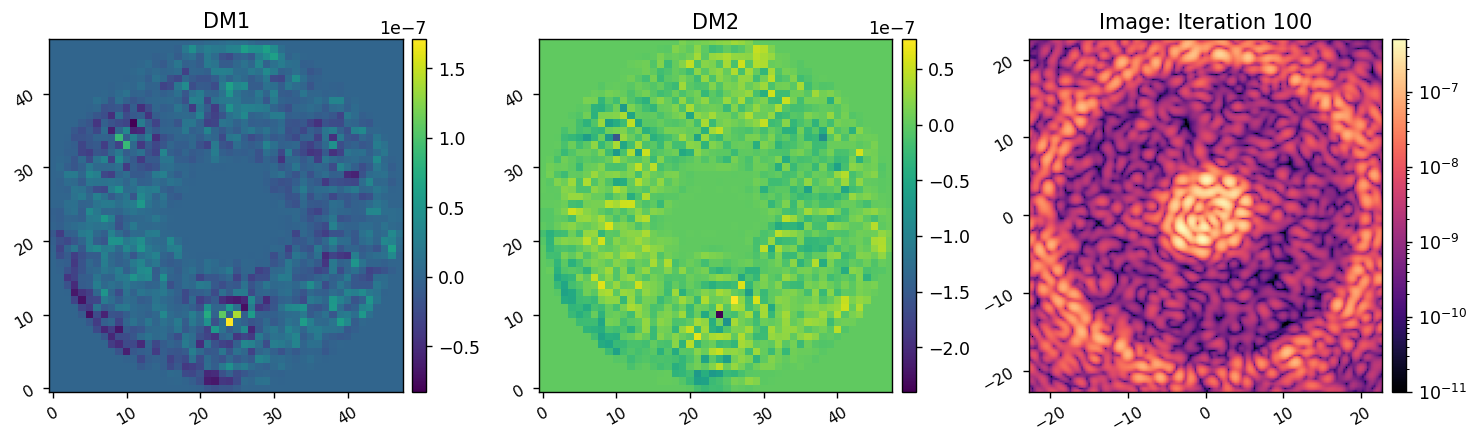

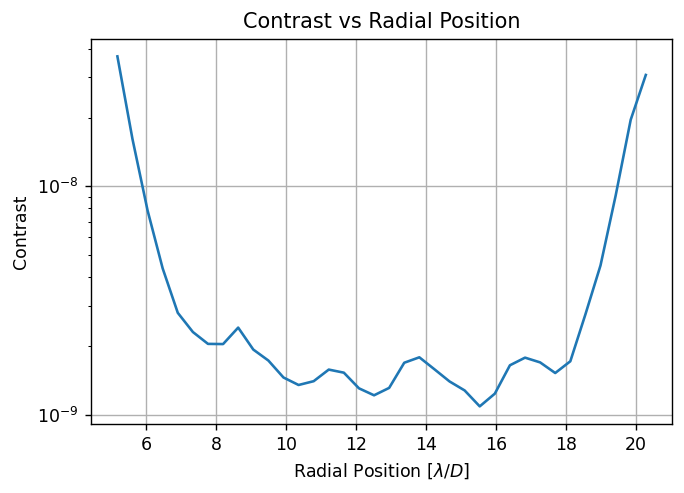

In [15]:
date = 20230921
dm1s = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_poke_modes_3pokes_images_{date}.fits')

poke_contrast = np.mean(ims[:,control_mask], axis=1)

i = 101
print(poke_contrast[i])
imshow3(dm1s[i], dm2s[i], ims[i], 
        'DM1', 'DM2', f'Image: Iteration {i-1}',
        cmap1='viridis', cmap2='viridis',
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

4.268038280524807e-08


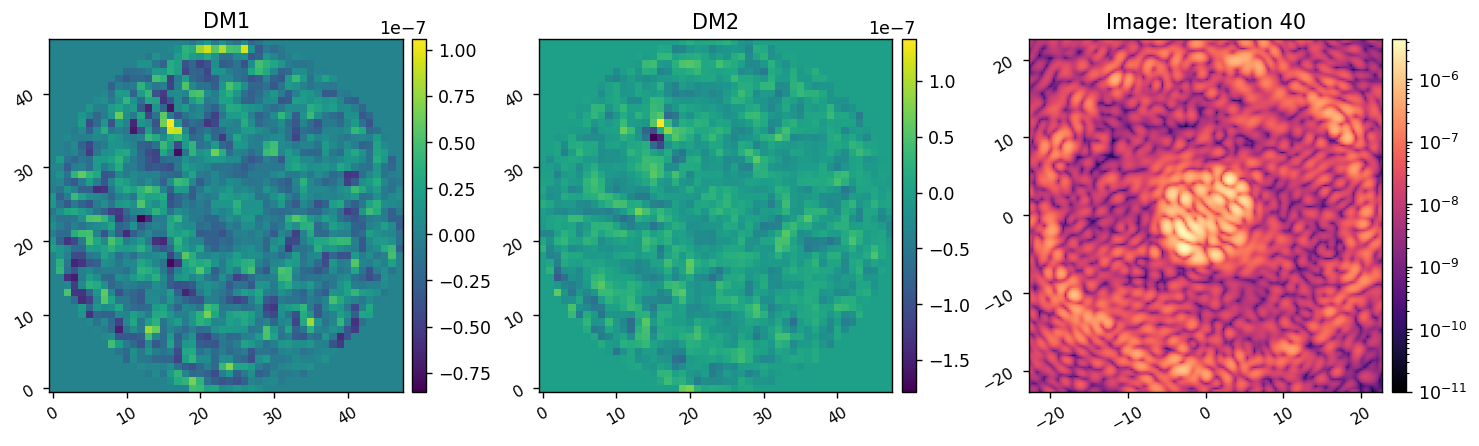

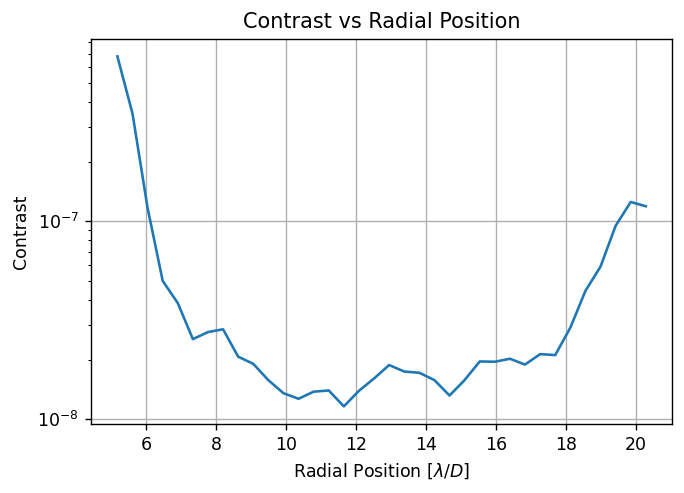

In [10]:
date = 20230926
dm1s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_3pokes_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_3pokes_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_fourier_modes_3pokes_images_{date}.fits')

fourier_contrast = np.mean(ims[:,control_mask], axis=1)
fourier_contrast.shape

i = 41

print(fourier_contrast[i])
imshow3(dm1s[i], dm2s[i], ims[i], 
        'DM1', 'DM2', f'Image: Iteration {i-1}',
        cmap1='viridis', cmap2='viridis',
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)

2.0974760780897488e-09


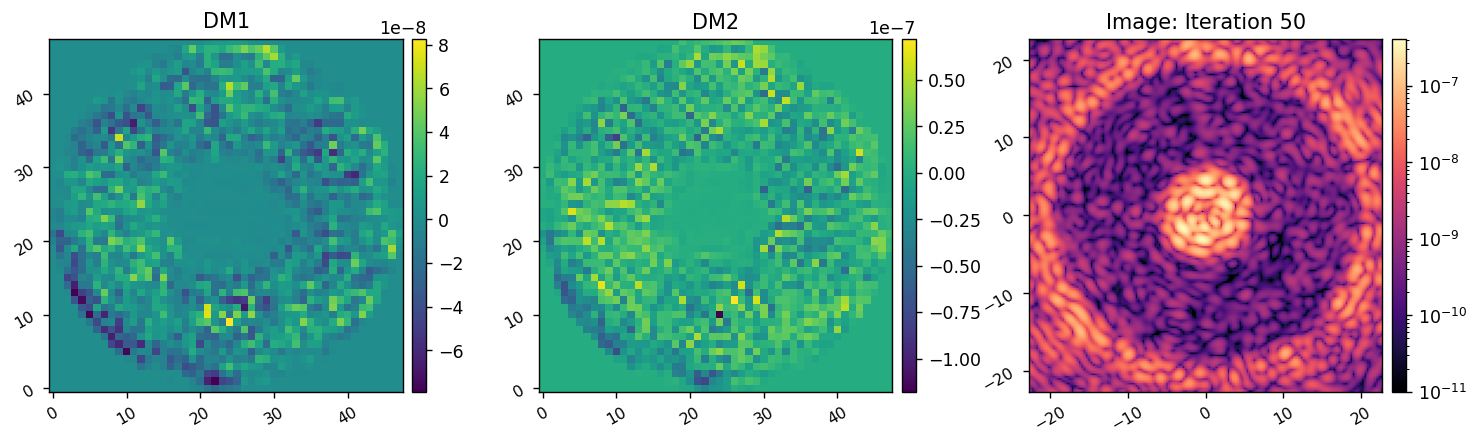

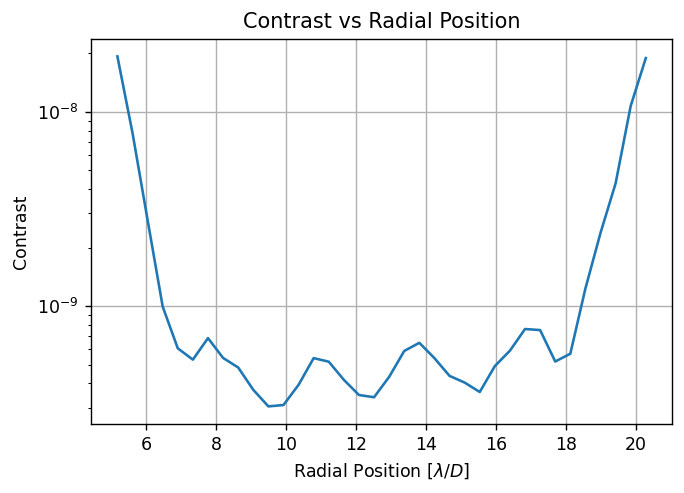

In [33]:
date = 20230925
dm1s = fits.getdata(response_dir/f'spc_wfov_825_had_dm1_commands_{date}.fits')
dm2s = fits.getdata(response_dir/f'spc_wfov_825_had_dm2_commands_{date}.fits')
ims = fits.getdata(response_dir/f'spc_wfov_825_had_images_{date}.fits')

had_contrast = np.mean(ims[:,control_mask], axis=1)

i = 51
print(had_contrast[i])
imshow3(dm1s[i], dm2s[i], ims[i], 
        'DM1', 'DM2', f'Image: Iteration {i-1}',
        cmap1='viridis', cmap2='viridis',
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
utils.plot_radial_contrast(ims[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)


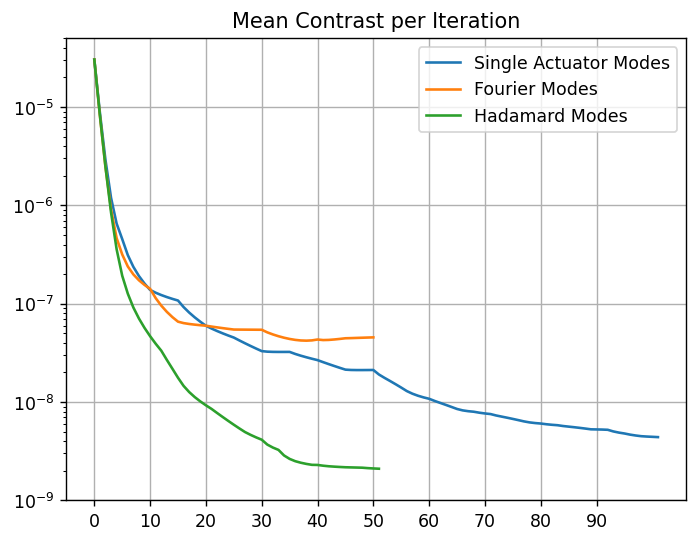

In [46]:
import matplotlib.pyplot as plt

plt.figure(dpi=125)

itrs = range(poke_contrast.shape[0])
plt.semilogy(itrs, poke_contrast, label='Single Actuator Modes')

itrs = range(fourier_contrast.shape[0])
plt.semilogy(itrs, fourier_contrast, label='Fourier Modes')

itrs = range(had_contrast.shape[0])
plt.semilogy(itrs, had_contrast, label='Hadamard Modes')

plt.ylim([1e-9, 5e-5])
plt.xticks(np.arange(0,100, 10))
plt.legend()
plt.title('Mean Contrast per Iteration')
plt.grid()

